<a href="https://colab.research.google.com/github/candicesheehan/MusselCNN/blob/main/Mussel_1_orthomosaic_to_tiles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inspect, Crop/Tile, and Export UAS Imagery

**Before running this script, create a Google Drive folder with just the orthomosaic you are going to use. You should also know the approximate pixel-length of your target object (here, a large seal) in your mosaic (this will become the `overlap` variable during tiling). The script is expecting a GeoTIFF file, so code tweaking is necessary if your mosaic is not that.**

<a href="https://colab.research.google.com/github/candicesheehan/MusselCNN/blob/master/1_orthomosaic_to_tiles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
#####  <center> Be sure to update this hyperlink above if you clone and want to point to a different GitHub </center>

### Connect to our Google Drive folder and pull tif files
Note: when you run this it will give you a link that you must click. You must give Google some permissions, then copy a code into a box that comes up in the output section of this code.

If customizing this code, you will need to point the `drive_folder` variable to a URL for your shared google drive folder.

In [1]:
!pip install -U -q PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# choose a local (colab) directory to store the data.
local_download_path = os.path.expanduser('mosaic')
try:
  os.makedirs(local_download_path)
except: 
  import glob
  files = glob.glob('data/*')
  for f in files:
    os.remove(f)

# 2. Auto-iterate using the query syntax
#    https://developers.google.com/drive/v2/web/search-parameters

# set variable to the destination google drive folder you want to pull from
drive_folder = 'https://drive.google.com/drive/folders/1A1YAbqRYxsTBgGAthXWLxLbW-IeVypjy'

# this bit points the code to that google drive folder
pointer = str("'" + drive_folder.split("/")[-1] + "'" + " in parents")

file_list = drive.ListFile(
    {'q': pointer}).GetList()

# this bit pulls all tif files from the directory specified above
for f in file_list:
  fname = os.path.join(local_download_path, f['title'])
  if fname.endswith(".tif"):
    f_ = drive.CreateFile({'id': f['id']})
    f_.GetContentFile(fname)
    print("Pulled file: " + fname)

Pulled file: mosaic/MX10-Pano.tif
Pulled file: mosaic/MX09-Pano.tif
Pulled file: mosaic/MX04-Pano.tif
Pulled file: mosaic/MX01-Pano.tif


### Identify orthomosaic file from among files in the input directory

In [3]:
# use this variable to set input directory
input_dir = local_download_path

orthomosaic_file = []
  
for fname in os.listdir(input_dir):
  candidate_file = "{i}/{f}".format(i=input_dir, f=fname)
  os.stat(candidate_file)
  # if the file is a *.tif and larger than 100 mb we label it the orthomosaic
  if os.stat(candidate_file).st_size > 10**7 :
    # if there are multiple orthomosaic files detected we spit an error
    if len(orthomosaic_file) != 0:
        raise Exception("more than one orthomosaic file identified based on size and type")
    orthomosaic_file = candidate_file
    print("orthomosaic identified as " + orthomosaic_file)

orthomosaic identified as mosaic/MX10-Pano.tif


### Set up the python environment and prep some variables

In [4]:
!pip install rasterio
!pip install pyproj
from PIL import Image
import os
import argparse
import numpy as np
import json
import csv
import rasterio
import matplotlib
import folium
from pyproj import Proj, transform


%matplotlib inline


Image.MAX_IMAGE_PIXELS = 100000000000

dataset = rasterio.open(orthomosaic_file)

     |████████████████████████████████| 19.1MB 247kB/s 
     |████████████████████████████████| 6.5MB 3.8MB/s 


/usr/local/lib/python3.7/dist-packages/rasterio/__init__.py:207: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


### Examine the metadata of the orthomosiac
This is mostly for checking/viewing info, but it does also set up some critical variables for later

In [5]:
# what is the name of this image
print('Image filename: {n}\n'.format(n=dataset.name))

# How many bands does this image have?
num_bands = dataset.count
print('Number of bands in image: {n}\n'.format(n=num_bands))

# How many rows and columns?
rows, cols = dataset.shape
print('Image size is: {r} rows x {c} columns\n'.format(r=rows, c=cols))

# Does the raster have a description or metadata?
desc = dataset.descriptions
metadata = dataset.meta

print('Raster description: {desc}\n'.format(desc=desc))

# What driver was used to open the raster?
driver = dataset.driver
print('Raster driver: {d}\n'.format(d=driver))

# What is the raster's projection?
proj = dataset.crs
print('Image projection:')
print(proj, '\n')

# What is the raster's "geo-transform"
gt = dataset.transform

print('Image geo-transform:\n{gt}\n'.format(gt=gt))

print('All raster metadata:')
print(metadata)
print('\n')

Image filename: mosaic/MX10-Pano.tif

Number of bands in image: 3

Image size is: 11043 rows x 9590 columns

Raster description: (None, None, None)

Raster driver: GTiff

Image projection:
None 

Image geo-transform:
| 1.00, 0.00, 0.00|
| 0.00, 1.00, 0.00|
| 0.00, 0.00, 1.00|

All raster metadata:
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 9590, 'height': 11043, 'count': 3, 'crs': None, 'transform': Affine(1.0, 0.0, 0.0,
       0.0, 1.0, 0.0)}




### Plot the image
Also mostly for viewing and confirming that things look appropriate

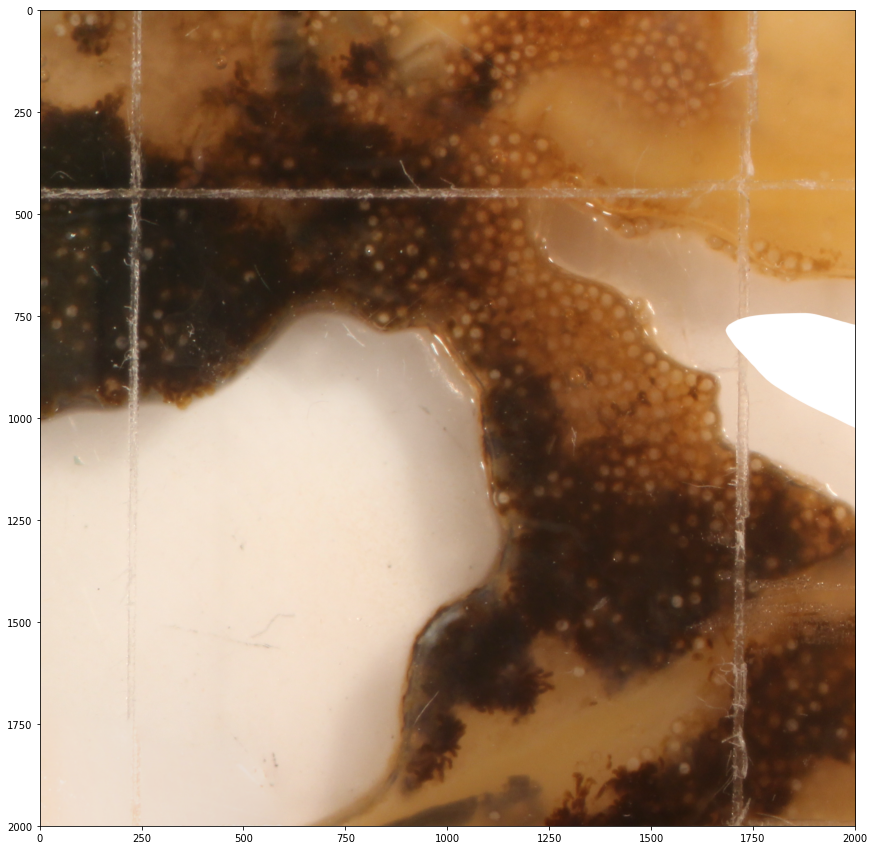

In [6]:
from rasterio.plot import show
from rasterio.windows import Window
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,15))

show(dataset.read((1,2,3), window=Window(5000, 5000, 2000, 2000)), transform=dataset.transform, ax=ax)
plt.show()

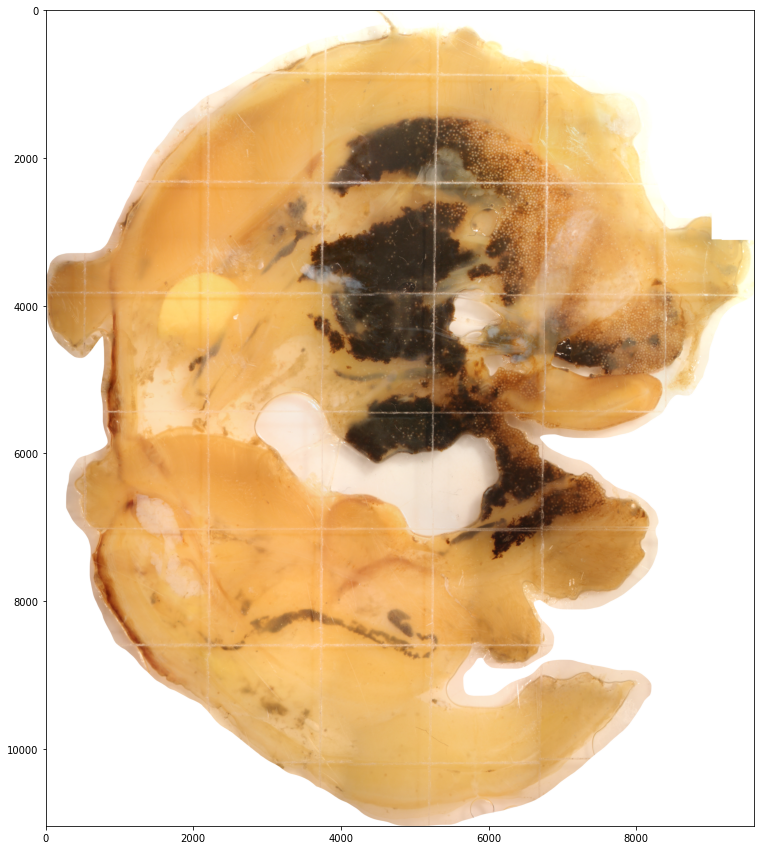

In [7]:
# plot the whole orthomosaic
fig, (axrgb) = plt.subplots(1, figsize=(15,15))
show(dataset.read(), transform=dataset.transform, ax=axrgb)
plt.show()

### Crop the Image into Tiles
This section breaks up the orthomosaic image into tiles. <b> It is important to set the `overlap` variable to the pixel-length of at least 1 target object (here, a seal) </b> in case the tiling process "cuts up" some of your objects into undetectable shapes at the edges. Adequate `overlap` ensures that a target object that gets "cut up" on one edge, will be intact in an adjacent image.

In [9]:
# set tile size (pixels): this is dictated by what constitutes a managable filesize for processing
tile_height = tile_width = 1000

# set overlap: this should equal 1–2x the pixel-length of our feature of interest
overlap = 60

stride = tile_height - overlap
start_num=0

def crop(orthomosaic_file, tile_height, tile_width, stride, img_dict, prj_name):
    im = Image.open(orthomosaic_file) 
    img_width, img_height = im.size
    print(im.size)
    print(img_width * img_height / (tile_height - stride) / (tile_width - stride))
    count = 0
    for r in range(0, img_height, stride):
        for c in range(0, img_width, stride):
            #tile = im[r:r+100, c:c+100]
            box = (c, r, c+tile_width, r+tile_height)
            top_pixel = [c,r]
            count += 1
            yield im.crop(box), top_pixel

### Split the image up into `height` × `width` patches

In [10]:
prj_name = orthomosaic_file.split(".")[0].split("/")[-1]
img = Image
img_dict = {}

# use this variable to set output directory
output_dir = 'tiled_data'
try:
  os.makedirs(output_dir)
except:  
  files = glob.glob('data/*')
  for f in files:
    os.remove(f)

# create the dir if it doesn't already exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# break it up into crops
for k, box_w_point in enumerate(crop(orthomosaic_file, tile_height, tile_width, stride, img_dict, prj_name), start_num):
    img=Image.new('RGB', (tile_height, tile_width), (255, 255, 255))
    img.paste(box_w_point[0])
    image_name = prj_name + "---%s.png" % k
    print(image_name)
    corner1, corner2, corner3, corner4 = img.load()[0, 0], img.load()[0, tile_height-1], img.load()[tile_width-1, tile_height-1], img.load()[tile_width-1, 0]
    if corner1 == corner2 == corner3 == corner4 == (0, 0, 0):
      print("empty tile, skipped")
      continue
    img_dict[image_name] = box_w_point[1]
    path=os.path.join(output_dir, image_name)
    img.save(path)

(9590, 11043)
29417.325
MX10-Pano---0.png
MX10-Pano---1.png
MX10-Pano---2.png
MX10-Pano---3.png
MX10-Pano---4.png
MX10-Pano---5.png
MX10-Pano---6.png
MX10-Pano---7.png
MX10-Pano---8.png
MX10-Pano---9.png
MX10-Pano---10.png
MX10-Pano---11.png
MX10-Pano---12.png
MX10-Pano---13.png
MX10-Pano---14.png
MX10-Pano---15.png
MX10-Pano---16.png
MX10-Pano---17.png
MX10-Pano---18.png
MX10-Pano---19.png
MX10-Pano---20.png
MX10-Pano---21.png
MX10-Pano---22.png
MX10-Pano---23.png
MX10-Pano---24.png
MX10-Pano---25.png
MX10-Pano---26.png
MX10-Pano---27.png
MX10-Pano---28.png
MX10-Pano---29.png
MX10-Pano---30.png
MX10-Pano---31.png
MX10-Pano---32.png
MX10-Pano---33.png
MX10-Pano---34.png
MX10-Pano---35.png
MX10-Pano---36.png
MX10-Pano---37.png
MX10-Pano---38.png
MX10-Pano---39.png
MX10-Pano---40.png
MX10-Pano---41.png
MX10-Pano---42.png
MX10-Pano---43.png
MX10-Pano---44.png
MX10-Pano---45.png
MX10-Pano---46.png
MX10-Pano---47.png
MX10-Pano---48.png
MX10-Pano---49.png
MX10-Pano---50.png
MX10-Pano---51.pn

### Create a .json file with all image names and geospatial metadata
This is important for storing how the tiles fit together, we will need this later to stitch our detections back together

In [11]:
full_dict = {"image_name" : orthomosaic_file,
            "image_locations" : img_dict,
             "crs" : str(dataset.crs)
            }
json_output = output_dir + '/spatial_data.json'

with open(json_output, 'w') as fp:
    json.dump({"orthomosaic_file":orthomosaic_file.split("/")[-1], "tile_height":tile_height, "tile_width":tile_width, "tile_pointers":full_dict}, fp)

### Zip data folder for download
This section downloads the tiles and `json` file describing the spatial data for each tile image

In [12]:
# zip up the tiles output directory into an archive for download
output_file_name = 'Step_1_{o}'.format(o=output_dir)
import subprocess
subprocess.call(['zip', '-r', output_file_name + '.zip', '/content/' + output_dir])

0

In [13]:
# download the zipped archive of your outputs from this code
from google.colab import files
files.download(output_file_name + ".zip")

#alternatively you can manually download the zipped archive from the Colab browser panel interface

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##### At the end of this script you should have downloaded all tile files and the spatial_data.json files. The tiles set should be ready for annotation in VIA to create training data. When you load the script to train the CNN, you will need the tiles and `spatial_data.json` file from this script (+ the `json` file from VIA, + annotation `csv` files that have been converted to RetinaNet format)

Next steps:

2) create annotations in VIA, save `csv` output

3) convert annotations from VIA format to RetinaNet format, with Training, Testing, and Validation subsets

4) train, refine, and test CNN using VIA annotations and the tiles generated here, produce precision metrics

5) export CNN outputs, manual annotations, and tile footprints as shapefiles


In [14]:
# if you just want to download the json file (e.g. for troubleshooting), click this bit of code:
from google.colab import files
files.download("/content/" + output_dir + "/spatial_data.json")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>